In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import sys

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_dense_adj

from preprocess import *
from utils import *
from model import *
from train import *

/Users/stella/anaconda3/envs/gdl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Dataset
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

torch.manual_seed(12345)

# Train test split
train_split = 0.8
batch_size = 16
visual_batch_size = 200
train_loader, val_loader, test_loader, visual_data_loader = prepare_data(dataset, train_split, batch_size, visual_batch_size)


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Class split - Training 0: 1901 1: 1568, Validation 0: 255 1: 179, Test 0: 245 1: 189


Epoch 1, Train Loss: 0.6142, Val Loss: 0.5706, Val Acc: 0.7235
Epoch 2, Train Loss: 0.5549, Val Loss: 0.5718, Val Acc: 0.6774
Epoch 3, Train Loss: 0.5322, Val Loss: 0.5761, Val Acc: 0.6889
Epoch 4, Train Loss: 0.5265, Val Loss: 0.5778, Val Acc: 0.6682
Epoch 5, Train Loss: 0.5086, Val Loss: 0.5177, Val Acc: 0.7673
Epoch 6, Train Loss: 0.5079, Val Loss: 0.5015, Val Acc: 0.7650
Epoch 7, Train Loss: 0.4960, Val Loss: 0.5181, Val Acc: 0.7535
Epoch 8, Train Loss: 0.4890, Val Loss: 0.5270, Val Acc: 0.7604
Epoch 9, Train Loss: 0.4926, Val Loss: 0.5714, Val Acc: 0.7235
Epoch 10, Train Loss: 0.4870, Val Loss: 0.5878, Val Acc: 0.6590
Epoch 11, Train Loss: 0.4854, Val Loss: 0.5398, Val Acc: 0.6982
Epoch 12, Train Loss: 0.4861, Val Loss: 0.5438, Val Acc: 0.7258
Epoch 13, Train Loss: 0.4826, Val Loss: 0.5204, Val Acc: 0.7396
Epoch 14, Train Loss: 0.4754, Val Loss: 0.5446, Val Acc: 0.7327
Epoch 15, Train Loss: 0.4760, Val Loss: 0.5581, Val Acc: 0.7258
Epoch 16, Train Loss: 0.4721, Val Loss: 0.5371, V

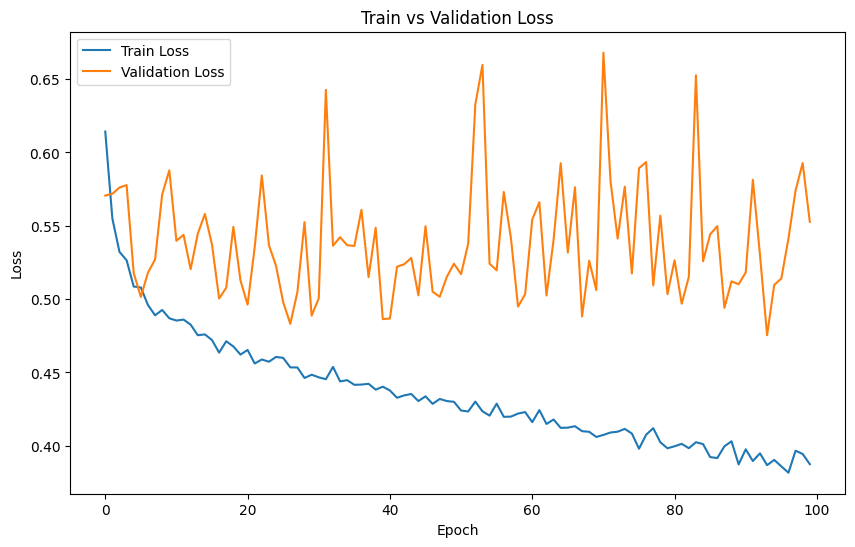

In [3]:
# Define the model
num_hidden_unit = 32
model_vanilla = Vanilla_GNN(dataset.num_features, num_hidden_unit, dataset.num_classes)
model_checkpoint_vanilla = 'vanilla_model_state_dict_best.pth'

# Training
lr = 0.001
epochs = 100
experiment_runner(model_vanilla, train_loader, val_loader, lr, epochs, model_checkpoint_vanilla)

In [4]:
model_vanilla0 = Vanilla_GNN(dataset.num_features, num_hidden_unit, dataset.num_classes)
model_vanilla0.load_state_dict(torch.load('vanilla_model_state_dict_best.pth'))
model_vanilla0.eval() 

criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = test(model_vanilla0, visual_data_loader, criterion)
print('Test Accuracy on Visual Data Loader:', test_acc)

Test Accuracy on Visual Data Loader: 0.7235023041474654


In [5]:
for data in visual_data_loader:
    
    adj = to_dense_adj(data.edge_index, data.batch)
    batched_x = pad_features(data)

    y_labels = data.y.tolist()
    
    graph_nodes = real_graph_node(data)
    
    out, x_gnn1_embed = model_vanilla0(batched_x, adj)
    
    break

In [6]:
from collections import Counter
graph_nodes_enumerate = [list(range(n)) for n in graph_nodes]

def cem_try(activation_space_before, graph_nodes_enumerate, DR_method, layer_num):
    relevant_features = []
    for idx, real_node_number in enumerate(graph_nodes_enumerate):
        # Extract the features for the relevant nodes in the graph
        relevant_features.append(activation_space_before[idx, real_node_number, :])
    # Concatenate all the relevant features along the first dimension
    features = torch.cat(relevant_features, dim=0)
    
    # CEM-clustering
    num_unique_rows, indices = cem_clustering(features)
    

    # Use Counter to count occurrences
    occurrences = Counter(indices.tolist())

    # Sort the occurrences dictionary by values
    sorted_occurrences = sorted(occurrences.items(), key=lambda x: x[1], reverse=True)

    # Optionally, convert back to dictionary if needed
    sorted_occurrences_dict = dict(sorted_occurrences)
    print(len(indices))
    print(sorted_occurrences_dict)

cem_try(x_gnn1_embed, graph_nodes_enumerate, 'TSNE', 'First DiffPool')

6490
{200: 1064, 105: 506, 70: 432, 71: 412, 7: 235, 195: 234, 0: 159, 283: 144, 135: 119, 10: 114, 190: 112, 240: 100, 118: 98, 369: 96, 198: 88, 30: 87, 212: 81, 87: 78, 179: 77, 275: 77, 101: 68, 132: 56, 367: 55, 223: 52, 20: 50, 196: 49, 205: 48, 131: 48, 393: 45, 114: 42, 396: 39, 46: 37, 103: 32, 204: 31, 271: 30, 281: 30, 28: 30, 72: 28, 218: 27, 38: 26, 401: 25, 8: 24, 27: 24, 6: 23, 107: 21, 202: 21, 86: 20, 2: 20, 226: 19, 16: 18, 1: 17, 178: 17, 13: 16, 15: 15, 128: 15, 102: 14, 415: 14, 91: 14, 293: 14, 277: 14, 352: 13, 138: 12, 219: 12, 159: 12, 395: 12, 11: 12, 318: 12, 251: 11, 193: 11, 253: 11, 117: 10, 220: 10, 171: 10, 92: 10, 22: 10, 56: 10, 59: 10, 5: 10, 197: 9, 162: 9, 209: 9, 252: 9, 45: 9, 123: 9, 376: 9, 98: 9, 371: 9, 188: 9, 317: 9, 242: 8, 32: 8, 47: 8, 68: 8, 75: 8, 255: 7, 264: 7, 244: 7, 359: 7, 64: 7, 14: 7, 31: 7, 256: 6, 370: 6, 207: 6, 3: 6, 208: 6, 408: 6, 322: 6, 187: 6, 221: 6, 211: 6, 12: 6, 289: 6, 379: 6, 210: 5, 247: 5, 60: 5, 61: 5, 133: 5, 

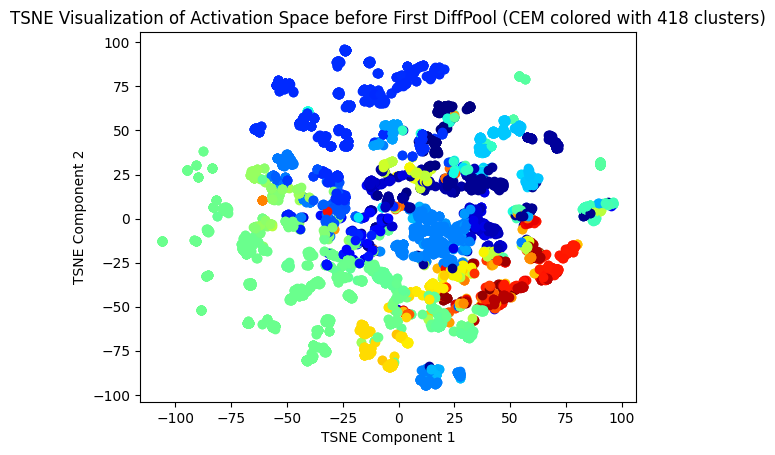

In [8]:
graph_nodes_enumerate = [list(range(n)) for n in graph_nodes]

def cem_plot(activation_space_before, graph_nodes_enumerate, DR_method, layer_num):
    relevant_features = []
    for idx, real_node_number in enumerate(graph_nodes_enumerate):
        # Extract the features for the relevant nodes in the graph
        relevant_features.append(activation_space_before[idx, real_node_number, :])
    # Concatenate all the relevant features along the first dimension
    features = torch.cat(relevant_features, dim=0)
    
    # CEM-clustering
    num_unique_rows, indices = cem_clustering(features)

    # Convert to numpy for dimensionality reduction
    features_np = features.detach().cpu().numpy()

    # Apply Dimension Reduction
    features_DR = dimension_reduction(features_np, DR_method)

    # ========================== Plotting Activation Space (Binarized-S colored) ==========================
    colors0 = plt.cm.jet(np.linspace(0, 1, num_unique_rows))

    for i, label in enumerate(indices):
        plt.scatter(features_DR[i, 0], features_DR[i, 1], color=colors0[int(label)], label=f'Cluster {int(label)}')

    plt.xlabel(f'{DR_method} Component 1')
    plt.ylabel(f'{DR_method} Component 2')
    plt.title(f'{DR_method} Visualization of Activation Space before {layer_num} (CEM colored with {num_unique_rows} clusters)')
    plt.show()  

cem_plot(x_gnn1_embed, graph_nodes_enumerate, 'TSNE', 'First DiffPool')